Dependencies

In [1]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# STL Decomposition
from statsmodels.tsa.seasonal import STL

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, TimeDistributed
from tensorflow.keras.utils import plot_model

Load Dataset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/ULTRAMAX RON 92/DATA/dataset_encoded.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919 entries, 0 to 1918
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1919 non-null   object 
 1   Inflasi YoY    1919 non-null   float64
 2   Temp Avg       1919 non-null   float64
 3   Humidity Avg   1919 non-null   int64  
 4   RR             1919 non-null   float64
 5   Produksi BM    1919 non-null   float64
 6   Produksi BP    1919 non-null   float64
 7   Produksi CR    1919 non-null   float64
 8   Bawang Merah   1919 non-null   float64
 9   Bawang Putih   1919 non-null   float64
 10  Cabai Rawit    1919 non-null   float64
 11  is_tahun_baru  1919 non-null   int64  
 12  is_idul_fitri  1919 non-null   int64  
 13  is_natal       1919 non-null   int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 210.0+ KB


Rename

In [3]:
df = df.rename(columns={
    'Date': 'date',
    'Inflasi YoY': 'inflasi_yoy',
    'Temp Avg': 'temp',
    'Humidity Avg': 'humidity',
    'RR': 'rainfall',
    'Produksi BM': 'produksi_bm',
    'Produksi BP': 'produksi_bp',
    'Produksi CR': 'produksi_cr',
    'Bawang Merah': 'bawang_merah',
    'Bawang Putih': 'bawang_putih',
    'Cabai Rawit': 'cabai_rawit'
})

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

STL Decomposition

In [4]:
df_stl = df.set_index('date')

# STL untuk Bawang Merah
stl_bm = STL(df_stl['bawang_merah'], period=7).fit()
df_stl['trend_bm'] = stl_bm.trend
df_stl['seasonal_bm'] = stl_bm.seasonal
df_stl['residual_bm'] = stl_bm.resid

# STL untuk Bawang Putih
stl_bp = STL(df_stl['bawang_putih'], period=7).fit()
df_stl['trend_bp'] = stl_bp.trend
df_stl['seasonal_bp'] = stl_bp.seasonal
df_stl['residual_bp'] = stl_bp.resid

# STL untuk Cabai Rawit
stl_cr = STL(df_stl['cabai_rawit'], period=7).fit()
df_stl['trend_cr'] = stl_cr.trend
df_stl['seasonal_cr'] = stl_cr.seasonal
df_stl['residual_cr'] = stl_cr.resid

df_stl = df_stl.reset_index()

Define 'Target Cols' and 'Feature Cols' and Scaling

In [5]:
features = [
    # STL dari ketiga komoditas
    'trend_bm', 'seasonal_bm', 'residual_bm',
    'trend_bp', 'seasonal_bp', 'residual_bp',
    'trend_cr', 'seasonal_cr', 'residual_cr',

    # Fitur lainnya
    'inflasi_yoy', 'temp', 'humidity', 'rainfall',
    'produksi_bm', 'produksi_bp', 'produksi_cr',
    'is_tahun_baru', 'is_idul_fitri', 'is_natal'
]

target = ['bawang_merah', 'bawang_putih', 'cabai_rawit']
data = df_stl[features + target].dropna()

# Scaling
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(data[features])
y_scaled = scaler_y.fit_transform(data[target])

Sequence Preparation

In [6]:
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

Build Model

In [7]:
input_layer = Input(shape=(window_size, X_seq.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(input_layer)
attention_out = Attention()([lstm_out, lstm_out])
concat = Concatenate()([lstm_out, attention_out])
dense = TimeDistributed(Dense(32, activation='relu'))(concat)
output = Dense(3)(dense[:, -1, :])

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 19)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 30, 64)    │     21,504 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 30, 64)    │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 128)   │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 30, 32)    │      4,128 │ concatenate[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 32)        │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │         99 │ get_item[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,731 (100.51 KB)

 Trainable params: 25,731 (100.51 KB)

 Non-trainable params: 0 (0.00 B)

Train Model

In [8]:
history = model.fit(X_seq, y_seq, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0262 - val_loss: 0.0122
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0044 - val_loss: 0.0069
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0024 - val_loss: 0.0065
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 8.7198e-04 - val_loss: 0.0024
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.6477e-04 - val_loss: 0.0029
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.4174e-04 - val_loss: 0.0018
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.0918e-04 - val_loss: 0.0021
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.3928e-04 - val_loss: 0.0017
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.1050e-04 - val_loss: 0.0012
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 

Evaluation

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_scaled = model.predict(X_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_seq)

target_names = ['Bawang Merah', 'Bawang Putih', 'Cabai Rawit']

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

for i, name in enumerate(target_names):
    print(f"\n=== {name} ===")
    print("MAE:", mean_absolute_error(y_true[:, i], y_pred[:, i]))
    print("RMSE:", np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i])))
    print("MAPE:", mape(y_true[:, i], y_pred[:, i]))
    print("R²:", r2_score(y_true[:, i], y_pred[:, i]))

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

=== Bawang Merah ===
MAE: 393.74913809654583
RMSE: 596.6447165194893
MAPE: 1.0723433656049906
R²: 0.9949660506961405

=== Bawang Putih ===
MAE: 200.18780246095824
RMSE: 318.4272751625485
MAPE: 0.5555235179984278
R²: 0.9980432206056359

=== Cabai Rawit ===
MAE: 1047.0741073825427
RMSE: 1375.4973946396285
MAPE: 1.994652598143342
R²: 0.9962789964403624


Visualization

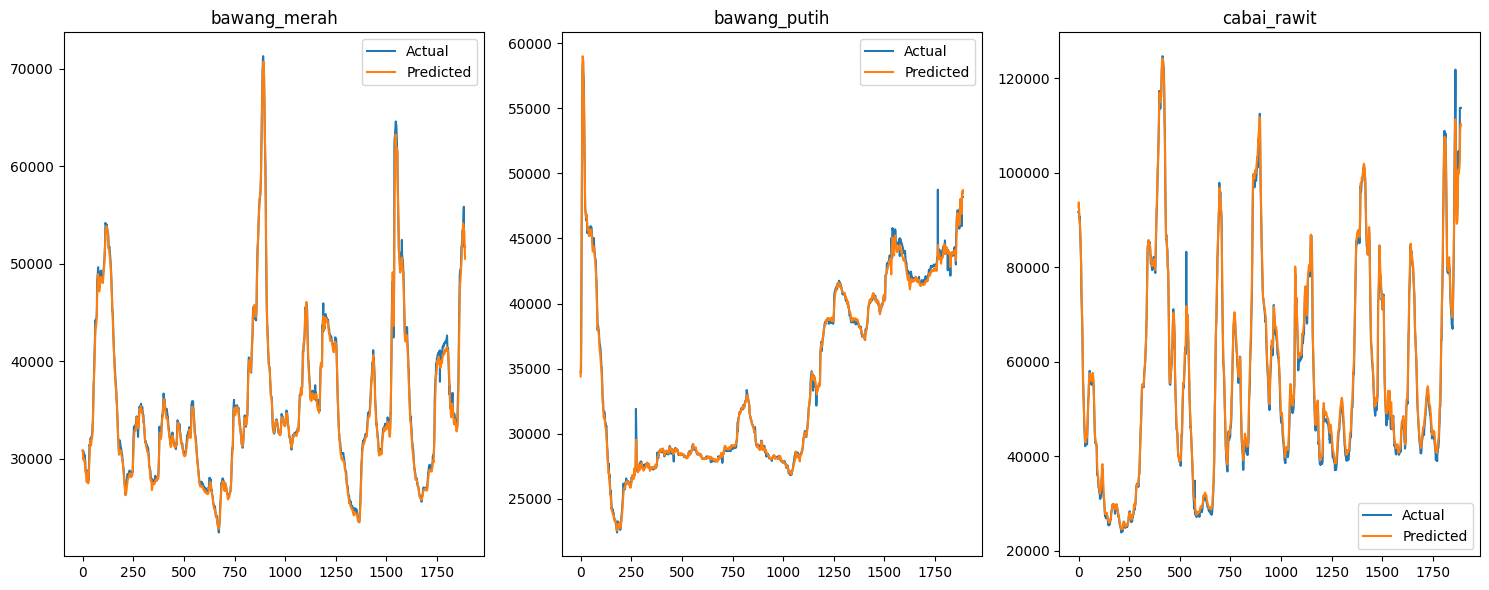

In [11]:
plt.figure(figsize=(15, 6))
for i, name in enumerate(target):
    plt.subplot(1, 3, i+1)
    plt.plot(y_true[:, i], label='Actual')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(name)
    plt.legend()
plt.tight_layout()
plt.show()

Save Model

In [12]:
model.save('multioutput_model.h5')

In [13]:
model.save('multioutput_model.keras')

Try to Forecast

In [14]:
n_hari = 14
forecast_input = X_scaled[-window_size:].copy()
forecast_scaled = []

for _ in range(n_hari):
    input_batch = forecast_input.reshape(1, window_size, -1)
    pred_scaled = model.predict(input_batch)[0]

    next_input = np.append(forecast_input[1:], [[*forecast_input[-1][:-3], *pred_scaled]], axis=0)
    forecast_input = next_input
    forecast_scaled.append(pred_scaled)

forecast_inverse = scaler_y.inverse_transform(np.array(forecast_scaled))
tanggal_awal = df_stl['date'].iloc[-1] + pd.Timedelta(days=1)
tanggal_prediksi = pd.date_range(start=tanggal_awal, periods=n_hari)

forecast_df = pd.DataFrame({
    'tanggal': tanggal_prediksi,
    'bawang_merah': forecast_inverse[:, 0],
    'bawang_putih': forecast_inverse[:, 1],
    'cabai_rawit': forecast_inverse[:, 2]
})

print("\n📅 Prediksi Harga Komoditas ({} hari ke depan):".format(n_hari))
print(forecast_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

📅 Prediksi Harga Komoditas (14 hari ke depan):
      tanggal  bawang_merah  bawang_putih    cabai_rawit
0  2025-04-01  49754.921875  48492.488281  109648.695312
1  2025-04-02  49809.664062  48817.234375  111113.609375
2  2025-04-03  49967.523438  48979.191406  113281.281250
3  2025-04-04  50303.949219  48969.691406  115215.757812
4  2025-04-05  50675.062500  48844.746094  116807.148438
5  2025-04-06  50946.960938  48619.890625  118051.617188
6  2025-04-07  51328.